In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models
import cv2 as cv
from PIL import Image

import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from tqdm.notebook import tqdm

In [37]:
data_dir = "C:\\Users\\amank\\X-Ray Model\\smaller data\\train"

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data Management and Augmentation

In [39]:
class X_Ray_Dataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.data = ImageFolder(data_dir, transform=transforms)
        self.data.classes = self.data.classes
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]


In [40]:
dataset = X_Ray_Dataset(data_dir)
print(dataset.data.classes)

['Cardiomegaly', 'Normal']


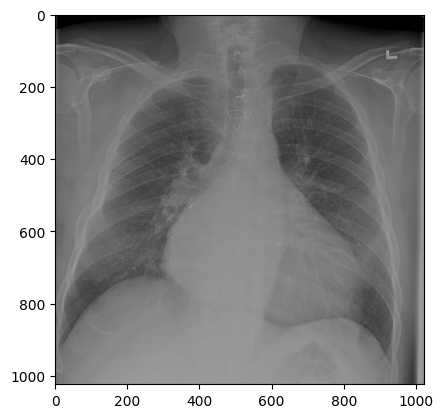

In [41]:
image, label = dataset[100]
plt.imshow(image)

In [42]:
len(dataset)

10145

In [43]:
def histogram_equalisation(image):
    image = np.array(image)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.equalizeHist(image)
    image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    return image

In [44]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAutocontrast(20) ,
    transforms.Lambda(lambda x:histogram_equalisation(x)),
    transforms.ToTensor()
])

dataset = X_Ray_Dataset(data_dir, transform)

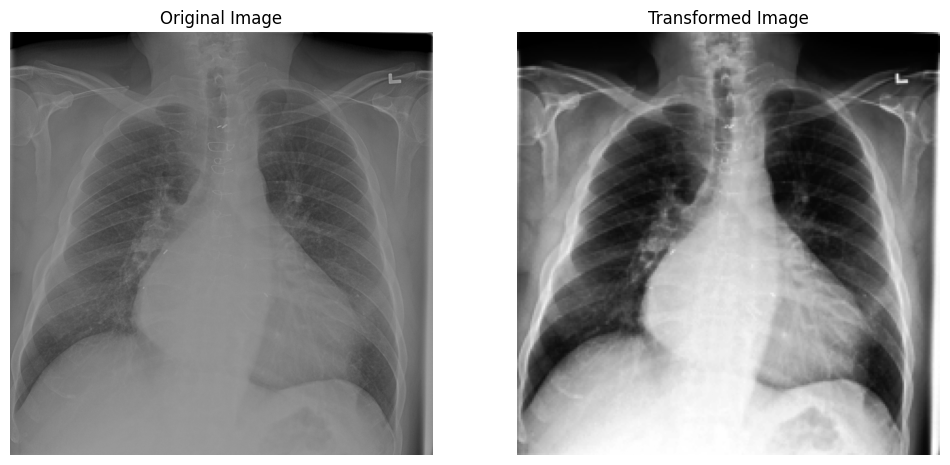

0


In [45]:
transformed_image = transform(image)
original_image = transforms.ToTensor()(image)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(original_image.permute(1, 2, 0))  
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(transformed_image.permute(1, 2, 0))  
axes[1].set_title("Transformed Image")
axes[1].axis('off')

plt.show()
print(label)

In [46]:
image, label = dataset[2]
image.shape

torch.Size([3, 224, 224])

In [47]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [48]:
def get_mean_and_std(loader):
    mean =  0.
    std = 0.
    total_image_count = 0
    for image, _ in tqdm(loader, desc='Calculating Mean and Std', unit='batch'):
        image_count_in_batch = image.size(0)
        image = image.view(image_count_in_batch, image.size(1), -1)
        mean += image.mean(2).sum(0)
        std += image.std(2).sum(0)
        total_image_count += image_count_in_batch

    mean /= total_image_count
    std /= total_image_count
    return mean, std


In [49]:
get_mean_and_std(dataloader)

Calculating Mean and Std:   0%|          | 0/318 [00:00<?, ?batch/s]

(tensor([0.4927, 0.4927, 0.4927]), tensor([0.2941, 0.2941, 0.2941]))

# Model Building and Testing

In [52]:
num_class = 2

class X_Ray_Classifier(nn.Module):
    def __init__(self, num_classes=num_class):
        super(X_Ray_Classifier, self).__init__()
        self.base_model = models.densenet121(weights='DEFAULT') 
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.base_model.classifier.in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

In [53]:
model = X_Ray_Classifier(num_classes=num_class)
print(str(model)[:500])

X_Ray_Classifier(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, m


In [54]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()    
])

dataset = X_Ray_Dataset(data_dir, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


for images, labels in dataloader:
    mages = images.to(device)  
    labels = labels.to(device)
    break
example = model(images)
print(example)


tensor([[-0.6720,  0.0754],
        [-0.7741,  0.5744],
        [-0.6334,  0.6788],
        [-0.5619,  0.3195],
        [-1.0266, -0.0684],
        [-0.4700,  0.3655],
        [-0.9498,  0.7887],
        [-0.7117,  0.1279],
        [-0.7620,  0.4777],
        [-0.4665,  0.9125],
        [-1.2937,  0.7685],
        [-1.1429,  0.3495],
        [-0.7370,  0.0546],
        [-0.6298,  0.1851],
        [-0.3850,  0.0194],
        [-0.3783, -0.0999]], grad_fn=<AddmmBackward0>)


In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [56]:
criterion(example.to(device), labels.to(device))

tensor(0.5598, device='cuda:0', grad_fn=<NllLossBackward0>)

# Training Model

In [57]:
mean = [0.4920, 0.4920, 0.4920]
std = [0.2943, 0.2943, 0.2943]


train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(5),
    transforms.Lambda(lambda x:histogram_equalisation(x)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x:histogram_equalisation(x)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [61]:
train_dir = r"C:\Users\amank\X-Ray Model\smaller data\train"
test_dir = r"C:\Users\amank\X-Ray Model\smaller data\test"
val_dir = r"C:\Users\amank\X-Ray Model\smaller data\val"

In [62]:
train_dataset = X_Ray_Dataset(train_dir, transforms=train_transform)
test_dataset = X_Ray_Dataset(test_dir, transforms=val_transform)
val_dataset = X_Ray_Dataset(val_dir, transforms=val_transform)

In [63]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [64]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

10145
2414
1473


In [65]:
from sklearn.metrics import accuracy_score
import time

model.to(device)
num_epoch = 30
train_losses, val_losses = [], []

early_stop_patience = 3
best_val_loss = float('inf')  
patience_counter = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-2)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

for epoch in range(num_epoch):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in tqdm(train_loader, desc=f'Training Epoch {epoch + 1}/{num_epoch}'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_losses.append(val_loss)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{num_epoch} - Train loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Time: {epoch_time:.2f}s")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'model.pth')
        print("Best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

    scheduler.step(val_loss)


Training Epoch 1/30:   0%|          | 0/318 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 1/30 - Train loss: 0.4326, Train Acc: 0.8115, Val loss: 0.3037, Val Acc: 0.8915, Time: 306.33s
Best model saved!


Training Epoch 2/30:   0%|          | 0/318 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 2/30 - Train loss: 0.3392, Train Acc: 0.8463, Val loss: 0.2662, Val Acc: 0.8964, Time: 349.44s
Best model saved!


Training Epoch 3/30:   0%|          | 0/318 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 3/30 - Train loss: 0.2824, Train Acc: 0.8754, Val loss: 0.2622, Val Acc: 0.8919, Time: 429.78s
Best model saved!


Training Epoch 4/30:   0%|          | 0/318 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 4/30 - Train loss: 0.2458, Train Acc: 0.8926, Val loss: 0.2288, Val Acc: 0.9138, Time: 444.03s
Best model saved!


Training Epoch 5/30:   0%|          | 0/318 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 5/30 - Train loss: 0.2209, Train Acc: 0.9096, Val loss: 0.2228, Val Acc: 0.9114, Time: 438.33s
Best model saved!


Training Epoch 6/30:   0%|          | 0/318 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 6/30 - Train loss: 0.1891, Train Acc: 0.9249, Val loss: 0.2327, Val Acc: 0.9002, Time: 422.49s


Training Epoch 7/30:   0%|          | 0/318 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 7/30 - Train loss: 0.1592, Train Acc: 0.9376, Val loss: 0.2577, Val Acc: 0.8960, Time: 433.19s


Training Epoch 8/30:   0%|          | 0/318 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch 8/30 - Train loss: 0.1361, Train Acc: 0.9476, Val loss: 0.2912, Val Acc: 0.8782, Time: 563.30s
Early stopping triggered.


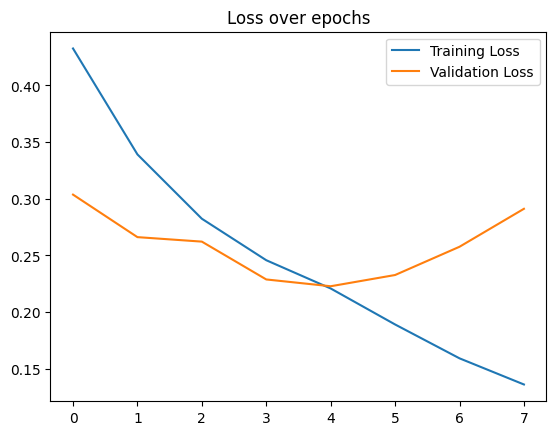

In [66]:
plt.plot(train_losses, label ="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss over epochs")
plt.xticks(range(len(train_losses)))
plt.show()

In [67]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

model = X_Ray_Classifier(num_classes=num_class)
model.to(device)
state_dict = torch.load('model.pth')
model.load_state_dict(state_dict)

y_true = []
y_pred = []

# Loop over the test set
with torch.no_grad():  # Disable gradient computation for inference
    for images, labels in tqdm(test_loader, desc="Testing Progress", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        # Get predictions from the model
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Collect true labels and predictions
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


C:\Users\amank\AppData\Local\Temp\ipykernel_19664\4278765526.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('model.pth')


Testing Progress:   0%|          | 0/47 [00:00<?, ?batch/s]

Test Accuracy: 0.4895
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.13      0.21       765
           1       0.48      0.88      0.62       708

    accuracy                           0.49      1473
   macro avg       0.51      0.50      0.42      1473
weighted avg       0.51      0.49      0.41      1473



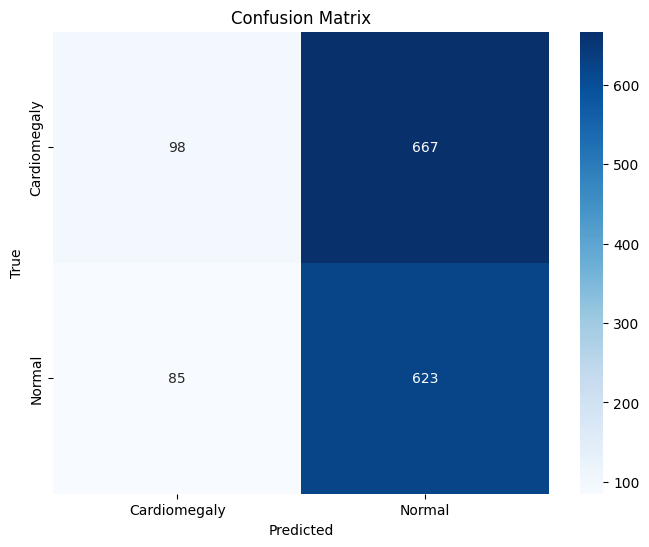

In [68]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.data.classes, yticklabels=test_dataset.data.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()